In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import string
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys

In [2]:
unknown_word_token = '<UNK>'
context_size = 2

porterStemmer = PorterStemmer()

minimum_frequency = 10

In [6]:
def read_corpus(title='bleak.txt'):
    with open(title, 'rt', encoding='utf-8-sig') as f:
        content = f.read()
    return content


def process(st):
    strip_chars = ['\'']
    for c in strip_chars:
        st = st.replace(c , '')

    rep_with_space_chars = [',', '.', '!', '?', '"', '-', ';', '(', ')']
    for c in rep_with_space_chars:
        st = st.replace(c , ' ')

    word_list = word_tokenize(st)
    word_list = [porterStemmer.stem(a.lower().strip()) for a in word_list]
    return word_list


def get_most_common(word_array):
    most_common_count = len({k:v for k, v in FreqDist(word_array).items() if v>minimum_frequency})
    c = Counter(words)
    most_common = [pair[0] for pair in c.most_common(most_common_count)]
    return most_common, most_common_count


def replace_unk(word_array, most_common_words):    
    words_with_unk = [word if word in most_common else unknown_word_token for word in word_array]
    return words_with_unk


def create_word_indices(words_with_unk):
    vocab = set(words_with_unk)
    print(len(vocab))

    index_to_word = {k:v for k, v in enumerate(vocab)}
    word_to_index = {v:k for k, v in index_to_word.items()}; 
    return index_to_word, word_to_index, vocab

def convert_window(words_with_unk):
    input = []
    for a in range(context_size, len(words_with_unk)-context_size):
        x = [item for sublist in [words_with_unk[a-context_size:a], words_with_unk[a+1:a+context_size+1], [words_with_unk[a]]] for item in sublist]
        input.append(x)
    return input


def convert_word_data_to_numbers(input):
    Xs = []
    Ys = []
    for row in input:
        Xs.append([word_to_index[word] for word in row[:-1]])
        Ys.append([word_to_index[word] for word in row[-1:]])

    X = np.vstack(Xs)
    Y = np.vstack(Ys)

    X_train_incl_val, X_test, Y_train_incl_val, Y_test = train_test_split(X, Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_incl_val, Y_train_incl_val)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test


def continue_fitting(model, initial_epoch, total_epochs):
    history = model.fit(X_train, Y_train, batch_size=64, epochs=total_epochs, initial_epoch=initial_epoch, callbacks=[], validation_data=(X_val, Y_val), verbose=1)
    return history


def save_model(model_to_save):
    model_to_save.save('saved_model/first_model')
    
    
def load_model():
    model = tf.keras.models.load_model('saved_model/first_model')
    model.summary()
    return model

def plot_and_eval(model, history):
    plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
    plt.legend()
    plt.show()
    model.evaluate(X_test, Y_test, batch_size=128)
    
def build_model():
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=len(vocab), output_dim=8))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(len(vocab), activation='softmax', name='output-layer'))
 
    model.compile(
    optimizer=keras.optimizers.RMSprop(),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    return model


In [10]:
books = ['bleak.txt']
words = []
for book in books:
    words += process(read_corpus(book))
most_common, most_common_count = get_most_common(words)
words_with_unk = replace_unk(words, most_common)

print()
print('only using top {} words. This is the first n words with {} token in place'.format(most_common_count, unknown_word_token))
print(words_with_unk[:10])

print()
print('Length of total vocabulary')
print(len(set(words)))

input = convert_window(words_with_unk)
print()
print('number of examples')
print(len(input))

print()
print('this is the words with {} broken into windows of 2 leading words, 2 following words and centre word'.format(unknown_word_token))
for i, window in enumerate(input[:5]):
    print('# {}'.format(i), window)

index_to_word, word_to_index, vocab = create_word_indices(words_with_unk)

gen = (item for item in word_to_index.items())

print()
print('The first of our words with their indexes')
print([next(gen) for _ in range(5)])

X_train, X_val, X_test, Y_train, Y_val, Y_test = convert_word_data_to_numbers(input)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)


only using top 2335 words. This is the first n words with <UNK> token in place
['the', 'project', 'gutenberg', 'ebook', 'bleak', 'hous', 'by', '<UNK>', '<UNK>', 'thi']

Length of total vocabulary
9241

number of examples
361160

this is the words with <UNK> broken into windows of 2 leading words, 2 following words and centre word
# 0 ['the', 'project', 'ebook', 'bleak', 'gutenberg']
# 1 ['project', 'gutenberg', 'bleak', 'hous', 'ebook']
# 2 ['gutenberg', 'ebook', 'hous', 'by', 'bleak']
# 3 ['ebook', 'bleak', 'by', '<UNK>', 'hous']
# 4 ['bleak', 'hous', '<UNK>', '<UNK>', 'by']
2336

The first of our words with their indexes
[('growth', 0), ('smile', 1), ('furnitur', 2), ('knew', 3), ('plainli', 4)]
(203152, 4) (67718, 4) (90290, 4) (203152, 1) (67718, 1) (90290, 1)


Train on 203152 samples, validate on 67718 samples
Epoch 1/2
203152/203152 [==============================] - 115s 567us/sample - loss: 5.7066 - sparse_categorical_accuracy: 0.0855 - val_loss: 5.5489 - val_sparse_categorical_accuracy: 0.1040
Epoch 2/2
203152/203152 [==============================] - 115s 564us/sample - loss: 5.5021 - sparse_categorical_accuracy: 0.1073 - val_loss: 5.5186 - val_sparse_categorical_accuracy: 0.1105


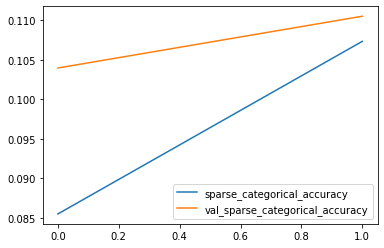

90290/90290 [==============================] - 6s 69us/sample - loss: 5.5165 - sparse_categorical_accuracy: 0.1105


In [44]:
model = build_model()
history = continue_fitting(model, 0, 2)
plot_and_eval(model, history)

In [46]:
def predict(sentence, model):
    input = convert_window(replace_unk(process(sentence), most_common))[0]
    print(input)
    indices = [word_to_index[word] for word in input]
    print(indices[:-1])
    prediction = model.predict(indices[:-1])
    averaged_predictions = layers.GlobalAveragePooling1D()(np.expand_dims(prediction, 0)).numpy()
    print(averaged_predictions.shape)
    predicted_words = []
    for index in np.argsort(np.squeeze(averaged_predictions))[:5]:
        predicted_words.append(index_to_word[index])
    return predicted_words

predict('The dog was sitting still', model)

['the', 'dog', 'sit', 'still', 'wa']
[853, 871, 1679, 258]
(1, 2336)


['deserv', 'itll', 'materi', 'deed', 'virtu']

# Location based hashing

A set of vectors in n-space can be partitioned by a hyperplane in n-1 dimensions.
To determine the side of the plane calculate the dot product of the vector and the normal vector of the plane.
In this way it is not necessary to explicitly specify the plane. The normal vectors can be chosen randomly instead.

In [3]:
n_dimensions = 3
n_planes = 2

planes = np.random.normal(size=(n_planes, n_dimensions))
planes

array([[-1.28436281,  0.94600479,  0.31160425],
       [-1.01938606,  0.91269729,  1.42380939]])

In [11]:
def get_hash(point):
    hash = 0
    index = 0
    for plane in planes:
        side = int(np.sign(np.dot(plane.T, point)))
        if side>0:
            hash+=2**index
        index +=1
    return hash

In [15]:
model = load_model()
model.weights

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 30)          70080     
_________________________________________________________________
embedding_average_layer_34 ( (None, 30)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 2048)              63488     
_________________________________________________________________
output-layer (Dense)         (None, 2336)              4786464   
Total params: 4,920,032
Trainable params: 4,920,032
Non-trainable params: 0
_________________________________________________________________


In [48]:
embeddings = model.layers[0].weights[0].numpy()
embeddings.shape

(2336, 8)

In [105]:
with open('weights.tsv', 'wt') as f:
    np.savetxt(f, embeddings, delimiter='\t')

with open('labels.tsv', 'wt') as f:
    for a in range(len(index_to_word)):
        f.write(index_to_word[a]+'\t\n')

In [107]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a*b)**2))

x = np.array([1,2,3])
y = np.array([2,2,2])
euclidean_distance(x, y)

7.483314773547883

In [119]:
index = np.random.randint(len(vocab))
reference_word = embeddings[index]
print(index_to_word[index])
min_word = (None, sys.maxsize)
for word in vocab:
    if index==word_to_index[word]:
        continue
    distance = euclidean_distance(embeddings[word_to_index[word]], reference_word)
    if distance<min_word[1]:
        min_word = (word, distance)


advic


In [120]:
min_word

('gay', 0.00046585425)